# Using Craigslist Data to Build a Predictive Model for Car Prices

In this project, we will explore car data scraped from [Craigslist](https://www.craigslist.org/) to find meaningful insights about the craigslist car market. We will then use these insights to construct a predictive model to predict the price listing.

Evaluating the car market on craigslist is a challenge, and there are different factors that can make it difficult to predict the price of a car. For example, there may be regional differences that can make it undesirable to purchase a car in a specific area. Using the data provided, we will clarify the most impactful factors that can affect the price of a used car.

### Summary of Results
- Since the year 2000, the average price of newer cars has increased drastically.
- The higher the odemeter reading, the lower the price.
- 8 cylinder cars are the most expensive gas powered cars, but are cheaper than electric cars.
- Wyoming has the highest average price for cars. The northwest in general has higher car prices than the rest of the country.



## Preparing the Data for Exploration and Modeling

Before we can begin exploring the data, we need to see how the data is structured and prepare it for analysis. In this project, we will use the following python libraries:

In [1]:
import pandas as pd
import numpy as np
from data_processing import * # stores functions used to clean data

import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.style as style
from plot import * # stores functions used to plot data

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# this library is for readability of code outputs inside jupyter notebook
from IPython.display import display_html

# %matplotlib inline

In [2]:
craigslist_raw = pd.read_csv('vehicles_sampled.csv')
craigslist_raw.head()

,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,...,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,95499,7088111186,https://mobile.craigslist.org/ctd/d/mobile-201...,mobile,https://mobile.craigslist.org,13950,2011.0,jeep,grand cherokee,excellent,...,rwd,NaN,SUV,NaN,https://images.craigslist.org/00g0g_hyUIVlBkjs...,2011 *** Jeep Grand Cherokee Limited SUV *** ...,NaN,al,30.6869,-88.2162
1,218089,7077594766,https://treasure.craigslist.org/ctd/d/melbourn...,treasure coast,https://treasure.craigslist.org,1000,2013.0,kia,optima,NaN,...,NaN,NaN,NaN,NaN,https://images.craigslist.org/01111_i0reK48zZ9...,TAX TIME SPECIAL!!!! 30TH YEAR ANNIVERSARY!!!!...,NaN,fl,28.1384,-80.6524
2,112125,7091613207,https://lexington.craigslist.org/ctd/d/finchvi...,lexington,https://lexington.craigslist.org,8490,2009.0,bmw,535xi,like new,...,4wd,full-size,sedan,blue,https://images.craigslist.org/00U0U_1A4UQ6Yjhc...,"2009 535xi BMW, All Wheel Drive, TanLeather In...",NaN,ky,38.0970,-85.3645
3,150313,7091696550,https://orlando.craigslist.org/ctd/d/tampa-201...,orlando,https://orlando.craigslist.org,36998,2017.0,ford,f-450,NaN,...,fwd,NaN,other,white,https://images.craigslist.org/00q0q_9aXLEGf6Tg...,2017 Ford F-450 Super Duty 4X2 4dr Crew Cab 17...,NaN,fl,28.0157,-82.4598
4,428076,7086364258,https://tulsa.craigslist.org/ctd/d/tulsa-2018-...,tulsa,https://tulsa.craigslist.org,40044,2018.0,chevrolet,silverado 1500,NaN,...,4wd,NaN,NaN,white,https://images.craigslist.org/00707_j4fmGFUS0C...,Mark Allen Chevrolet address: 8300 New Sapu...,NaN,ok,36.0446,-96.0783


Before cleaning the data, let's answer the following questions for each column:
- How many missing values are there?
- What percent of the data is missing?
- What are the data types?

In [3]:
craigslist_raw_null_values = explore_null_values(craigslist_raw)
craigslist_raw_null_values.sort_values(by="null_counts")

,null_counts,null_pct,data_types
Unnamed: 0,0,0%,int64
url,0,0%,object
state,0,0%,object
region_url,0,0%,object
description,0,0%,object
region,0,0%,object
price,0,0%,int64
id,0,0%,int64
image_url,0,0%,object
year,21,0%,float64


### Cleaning the data

#### Removing Unnecessary Columns
Given the information above in conjuction with the data dictionary given, the following columns are not useful for the purpose of this project:
- `Unnamed: 0`
- `id`
- `url`
- `region_url`
- `title_status`
- `model`
- `vin`
- `paint_color`
- `lat`, `long`, and `region` will be removed because we will use the `state` column.


#### Dealing with Missing Values

##### Too Many Missing Values

The following columns have too many missing values and would be too difficult to search for in the `description` column:
- `condition`
- `size`
- `county`

These columns will be dropped along with the unnecessary columns.

##### Small Amount of Missing Values

For the following columns, we will drop the rows with missing values since they amount to less than five percent of the total data:
- `fuel`
- `manufacturer`
- `model`
- `transmission`

##### Searching the Description Column for Missing Values

For the following columns, we will use regular expressions to search the `description` column to fill the missing values:
- `year`
- `cylinders`
- `type`

After searching the `description` column, the column will be dropped as it will no longer be needed.

In [4]:
craigslist = craigslist_raw.copy()

drop_unnecessary_columns(craigslist)

drop_low_pct_missing_values(craigslist)

clean_year_column(craigslist)

clean_cylinder_column(craigslist)

clean_type_column(craigslist)

craigslist.drop(columns=["description"], inplace=True)

Let's see what the data looks like after removing the unnecessary columns and filling in the missing values using the `description` column.

In [5]:
display_null_dataframes_side_by_side(craigslist_raw, craigslist)
print(f'\nNumber of rows removed: {craigslist_raw.shape[0] - craigslist.shape[0]}')
print(f'Percent of data from original dataset removed: {round((craigslist_raw.shape[0] - craigslist.shape[0])/craigslist_raw.shape[0]*100, 2)}%')

,null_counts,null_pct,data_types
cylinders,4387,41%,object
drive,3140,29%,object
fuel,76,1%,object
manufacturer,420,4%,object
odometer,1983,18%,float64
price,0,0%,int64
state,0,0%,object
transmission,78,1%,object
type,2954,27%,object
year,21,0%,float64



Number of rows removed: 562
Percent of data from original dataset removed: 5.21%


So far, we have been able to:
- Reduce the missing values in the `cylinders` and `type` columns by approximately 13%.
- Fill in all of the missing values in the `year` column except one row which was dropped. 

We accomplished all of this while only removing 562 rows, which is about 5% of the data.

There is still too much missing data to build a predictive model, and dropping the missing data will greatly affect the quality of our model. Let's see if we can find a way to fill in the missing data with some statistics and the `manufacturer` column. 

##### Removing Outliers

Before we can impute the missing values, we need to make sure that the outliers are removed. This will ensure that the imputed values are not influenced by the outliers.

The following columns will be checked for outliers: 
- `price`
- `odometer`
- `year`

In [6]:
craigslist.describe().apply(lambda x: x.apply('{0:.2f}'.format))

,price,year,odometer
count,10233.00,10233.00,8396.00
mean,322068.15,2010.03,99965.40
std,31312660.23,8.27,79611.98
min,0.00,1927.00,0.00
25%,4300.00,2007.00,48901.00
50%,9500.00,2012.00,94224.00
75%,17750.00,2015.00,137087.50
max,3167547323.00,2020.00,3000051.00


As you can see above, the `price` and `odometer` columns have minimum values equal to zero and maximum values that are not likely. Therefore, we will remove:
- any row with a `price` less than \$1000 or a price above $100,000
- any row with an `odometer` value less than 10,000 miles or above 300,000 miles. 

This will remove any listing that is most likely a scam. 

For the `year` column, we will remove cars that were made before 1985.

In [7]:
print('BEFORE REMOVING OUTLIERS')
print('------------------------')
print("Number of rows in dataset:", craigslist.shape[0])
print(f'Percent of data from original dataset removed: {round((craigslist_raw.shape[0] - craigslist.shape[0])/craigslist_raw.shape[0]*100, 2)}%\n\n')

craigslist = craigslist[craigslist["price"].between(1000, 500000, inclusive="neither")]
craigslist = craigslist[craigslist["odometer"].between(10000.0, 300000.0, inclusive="neither")]
craigslist = craigslist[craigslist["year"] > 1985]

print('AFTER REMOVING OUTLIERS')
print('------------------------')
print("Number of rows in dataset:", craigslist.shape[0])
print(f'Percent of data from original dataset removed: {round((craigslist_raw.shape[0] - craigslist.shape[0])/craigslist_raw.shape[0]*100, 2)}%')

BEFORE REMOVING OUTLIERS
------------------------
Number of rows in dataset: 10233
Percent of data from original dataset removed: 5.21%


AFTER REMOVING OUTLIERS
------------------------
Number of rows in dataset: 7169
Percent of data from original dataset removed: 33.59%


As seen above about 28% of our data was likely a scam, incorrectly inputed data, or data corruption. This is why car buyers should be careful when purchasing cars on craigslist.

##### Imputing Missing Values 

For the following categorical columns, we will use the mode of the columns grouped by the `manufacturer` column to impute the missing values:
- `cylinders`
    -  teslas have no cylinders so we will impute them with 0
- `drive`
- `type`

This will gives us the most frequent value for each manufacturer for the columns above.

For the `odometer` column, we will use the median of the column to impute the missing values.

In [8]:
impute_cylinders_with_mode(craigslist)

impute_drive_with_mode(craigslist)

impute_type_with_mode(craigslist)

impute_odometer_with_median(craigslist)

In [9]:
craigslist_null_values = explore_null_values(craigslist)
craigslist_null_values

,null_counts,null_pct,data_types
cylinders,0,0%,int64
drive,0,0%,object
fuel,0,0%,object
manufacturer,0,0%,object
odometer,0,0%,int64
price,0,0%,int64
state,0,0%,object
transmission,0,0%,object
type,0,0%,object
year,0,0%,int64


Now we have a fully cleaned dataset that can be explored and used for predictive modeling.

## Exploring the Data

Intuitively, the columns that may be the most useful for our model are:
- `year`: The newer the car, the more likely the price is to be higher.
- `odometer`: The lower the odometer, the more likely the price is to be higher.
- `cylinders`: The higher the cylinder, the more likely the price is to be higher.
- `state`: There may be regional differences in the prices of cars.

These are the columns that we will explore in the following sections.

### Price by Year


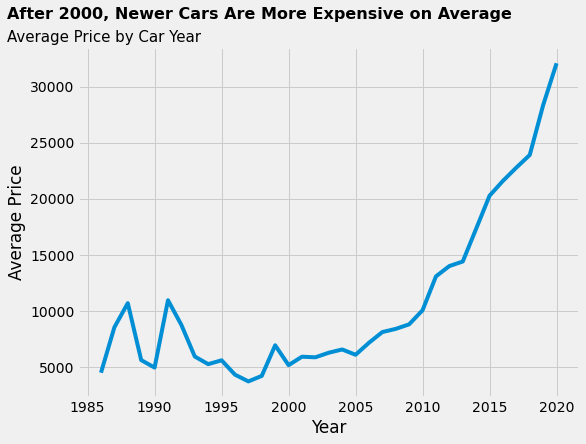

In [10]:
year_gb = craigslist.groupby("year")["price"].mean()
plot_line_chart(
    year_gb, 
    title='After 2000, Newer Cars Are More Expensive on Average',
    subtitle='Average Price by Car Year',
    x_label='Year', 
    y_label='Average Price',
    x_text=1979,
    y1_text=36000,
    y2_text=34000
    )

### Price by Odometer Reading

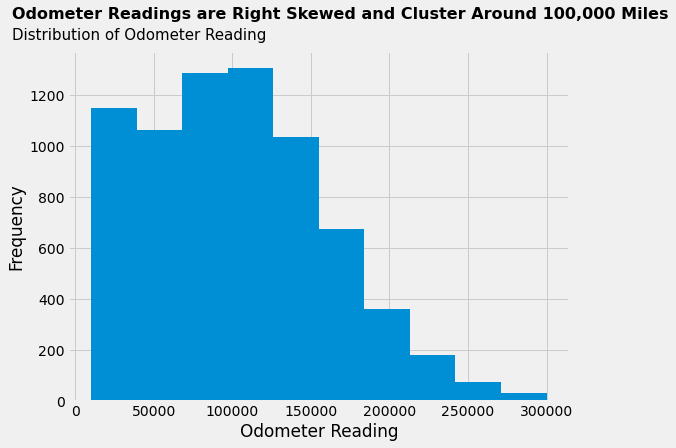

In [11]:
plot_histogram(
    craigslist['odometer'],
    title='Odometer Readings are Right Skewed and Cluster Around 100,000 Miles',
    subtitle='Distribution of Odometer Reading',
    x_label='Odometer Reading',
    y_label='Frequency',
    x_text=-40000,
    y1_text=1500,
    y2_text=1420
    )

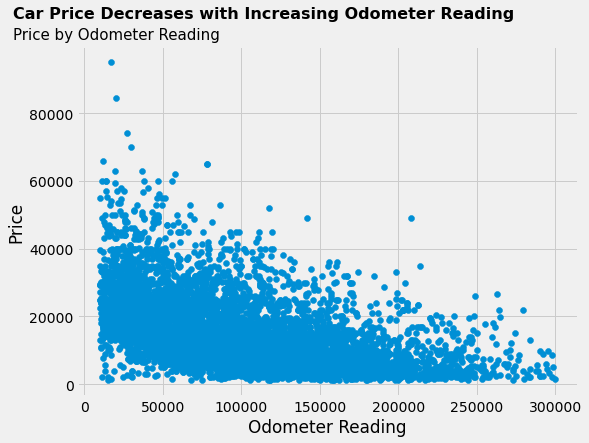

In [12]:
plot_scatter_plot(
    craigslist,
    x_axis='odometer',
    y_axis='price',
    title='Car Price Decreases with Increasing Odometer Reading',
    subtitle='Price by Odometer Reading',
    x_label='Odometer Reading',
    y_label='Price',
    x_text=-45000,
    y1_text=108000,
    y2_text=102000,
)


### Price by Cylinders

Text(0, 0.5, 'Average Price')

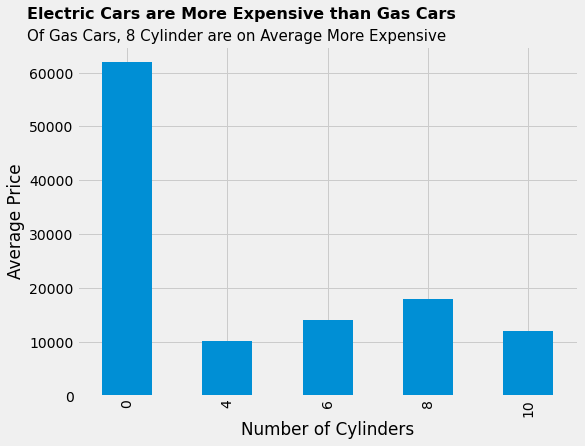

In [13]:
cylinder_gb = craigslist.groupby("cylinders")["price"].mean().astype(int)
ax = cylinder_gb.plot.bar(figsize=(8,6))
# Title
ax.text(x=-1, y=70000, s='Electric Cars are More Expensive than Gas Cars', fontsize=16, weight="bold")
# Subtitle
ax.text(x=-1, y=66000, s="Of Gas Cars, 8 Cylinder are on Average More Expensive", fontsize=15)
plt.xlabel('Number of Cylinders')
plt.ylabel('Average Price')


### Price by State

In [14]:
craigslist['state'] = craigslist['state'].str.upper()
state_gb = craigslist.groupby('state')[['price']].mean().reset_index()
fig = px.choropleth(
    state_gb,
    locations='state',
    locationmode='USA-states',
    scope='usa',
    color='price',
    color_continuous_scale='Viridis_r'
)
fig.update_layout(
    title_text='Average Car Price Listing by State',
    title_font_size=20,
    title_font_color='black',
    title_x=0.5,
)
fig.show()

In the map above we can see that Wyoming is the state with the highest average car price and that the northwest has higher average car prices than the rest of the country.

## Developing a Predictive Model for Car Price Listing

For our predictive model, we will use a univariate linear regression model. We will use the `year` column since there is a positive correlation between the price of a car and the year it was made.

In [15]:
craigslist[['year', 'price']].corr()

,year,price
year,1.000000,0.578372
price,0.578372,1.000000


As shown above, the `year` column is moderately correlated with the `price` column. This correlation may indicate that the `year` column is a good predictor for `price`.

In [16]:
train, test = train_test_split(craigslist, test_size=0.2, random_state=1)
uni_lr = LinearRegression()
uni_lr.fit(train[['year']], train['price'])

test['predicted_price'] = uni_lr.predict(test[['year']])
train['predicted_price'] = uni_lr.predict(train[['year']])

train_mse = mean_squared_error(train['price'], train['predicted_price'])
train_rmse = train_mse ** (1/2)

test_mse = mean_squared_error(test['price'], test['predicted_price'])
test_rmse = test_mse ** (1/2)

print(f'Train MSE: {train_mse}')
print(f'Train RMSE: {train_rmse}')
print()
print(f'Test MSE: {test_mse}')
print(f'Test RMSE: {test_rmse}')


Train MSE: 69357004.80453146
Train RMSE: 8328.085302428852

Test MSE: 65295165.90485783
Test RMSE: 8080.54242640046


We can see from the RMSE values above that our model performed better on the test data than on the training data. Given the small amount of data and the moderate correlation of the `year` column this model is unlikely to yield great predictions for the price listing of a car on craigslist. 

The next steps for improving the model would be:
- Encode the categorical variables and use a multivariate linear regression model
- Scrape more data from craigslist
- Develop more robust cleaning and imputation methods. 

## Conclusion

In this project we analyzed data scraped from craigslist to find meaningful insights about the craigslist car market. We then used these insights to construct a linear regression model to predict the price listing of a car. The most interesting insight we found was that Wyoming has the highest average price for cars. Moreover, our findings showed the expected results, newer cars are more likely to be more expensive than older cars and the lower the odometer, the more likely the price is to be higher.